# LSTM: Air Passengers

based on https://github.com/mikel-brostrom/flight-passengers-prediction-LSTM/blob/master/flight_passengers_prediction_LSTM.ipynb

In [1]:
import compyute as cp

## Prepare the Data

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

# download the dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
data = pd.read_csv(url)
tensor = cp.tensor(data.iloc[:,1].values)

In [3]:
# scale values
scaled_tensor = cp.preprocessing.normalize(tensor)

# save values for inverse transformation
train_max = tensor.max().item()
train_min = tensor.min().item()

# apply a sliding window
lookback = 4
windowed_tensor = cp.pooling1d(scaled_tensor, window_size=lookback+1)

x = windowed_tensor[:, :-1, cp.newaxis]
y = windowed_tensor[:, -1, cp.newaxis]

# create train and test splits
train_size = int(len(y) * 0.4)
X_train = x[:train_size]
y_train = y[:train_size]

print(f"{x.shape=}")
print(f"{y.shape=}")
print(f"{X_train.shape=}")
print(f"{y_train.shape=}")

x.shape=(140, 4, 1)
y.shape=(140, 1)
X_train.shape=(56, 4, 1)
y_train.shape=(56, 1)


## Build the Neural Network

In [4]:
from compyute import nn

lstm = nn.Sequential(
    nn.LSTM(1, 2),
    nn.Slice(":, -1, :"),  # only use last element of the sequence
    nn.Linear(2, 1)
)

In [5]:
summary = cp.nn.utils.get_module_summary(lstm, input_shape=(lookback, 1))
print(summary)

Sequential
Layer                          Input Shape      Output Shape     # Parameters    trainable
Sequential                     (4, 1)           (1,)                        0         True
├─LSTM                         (4, 1)           (4, 2)                     40         True
├─Slice                        (4, 2)           (2,)                        0         True
└─Linear                       (2,)             (1,)                        3         True
Parameters: 43
Trainable parameters: 43


## Training

In [6]:
from compyute.nn.trainer import Trainer
from compyute.nn.trainer.callbacks import History, ProgressBar

epochs = 2000
optim = nn.optimizers.Adam(lstm.get_parameters(), lr=0.01)
history = History()
progress = ProgressBar(mode="epoch")

trainer = Trainer(
    model=lstm,
    optimizer=optim,
    loss="mse",
    callbacks=[history, progress],
)

trainer.train(X_train, y_train, epochs=epochs, batch_size=-1)

  0%|          | 0/2000 [00:00<?, ? epochs/s]

## Evaluate Model

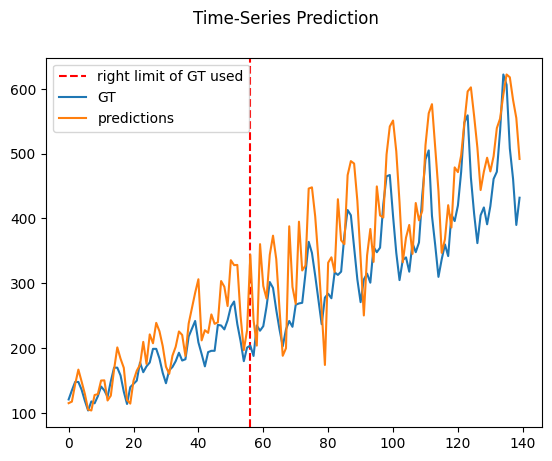

In [7]:
lstm.inference()
y_pred = lstm(x)
y_pred_scaled = cp.preprocessing.normalize(y_pred, low=train_min, high=train_max)  # rescale outputs to the original scale
y_scaled = cp.preprocessing.normalize(y, low=train_min, high=train_max)  # rescale outputs to the original scale

plt.axvline(x=train_size, c='r', linestyle='--', label='right limit of GT used')
plt.plot(y_scaled, label='GT')
plt.plot(y_pred_scaled, label='predictions')
plt.suptitle('Time-Series Prediction')
plt.legend()
plt.show()